In [1]:
# --- Step 1: Import Libraries and Load Data ---

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files

# Import necessary libraries from scikit-learn and TensorFlow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, Bidirectional # Import GRU and Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# --- Data Loading ---
print("Please upload your 'control_surface_vibrations_100k.csv' file.")
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

print("\nDataset shape:", df.shape)
print("First 5 rows of the dataset:")
print(df.head())

Please upload your 'control_surface_vibrations_100k.csv' file.


Saving control_surface_vibration_modes_100k.csv to control_surface_vibration_modes_100k.csv

Dataset shape: (100000, 10)
First 5 rows of the dataset:
  Surface_Type     Material  Length_m  Width_m  Thickness_m  Airspeed_mps  \
0       Rudder     Titanium      1.93     0.28        0.020         174.6   
1       Rudder  CarbonFiber      1.00     0.49        0.027         219.1   
2     Elevator     Titanium      1.40     0.44        0.025          93.5   
3     Elevator  CarbonFiber      1.63     0.29        0.010         179.5   
4      Aileron     Titanium      1.64     0.38        0.029         195.9   

   Angle_of_Attack_deg  Mode_Number  Natural_Freq_Hz  Damping_Ratio  
0                 13.5            3            15.27          0.031  
1                 11.8            1            12.60          0.026  
2                  8.4            3            17.54          0.038  
3                 -4.2            3            14.80          0.034  
4                  1.6            2  

In [2]:
# --- Step 2: Define Features (X) and Targets (y) ---

if 'Surface_Type' in df.columns and 'Material' in df.columns:
    df = pd.get_dummies(df, columns=['Surface_Type', 'Material'], drop_first=True)
    print("\nDataset shape after one-hot encoding:", df.shape)

target_cols = ['Natural_Freq_Hz', 'Damping_Ratio']
X = df.drop(columns=target_cols)
y = df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


Dataset shape after one-hot encoding: (100000, 12)


In [3]:
# --- Step 3: Scale Features and Targets ---

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_scaled = x_scaler.fit_transform(X_train)
X_test_scaled = x_scaler.transform(X_test)

y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# --- Step 4: Reshape Features for GRU Input ---

X_train_stacked = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_stacked = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [4]:
# --- Step 5: Define the Bidirectional GRU Model ---

model = Sequential()

# First Bidirectional GRU layer. return_sequences=True is needed for stacking.
model.add(Bidirectional(GRU(128, activation='tanh', return_sequences=True),
                        input_shape=(X_train_stacked.shape[1], X_train_stacked.shape[2])))
model.add(Dropout(0.2))

# Second Bidirectional GRU layer.
model.add(Bidirectional(GRU(64, activation='tanh')))
model.add(Dropout(0.2))

# Dense layers for processing
model.add(Dense(32, activation='relu'))

# Output layer for regression (2 outputs, linear activation)
model.add(Dense(2, activation='linear'))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

print("\nBidirectional GRU Regression Model Summary:")
model.summary()


Bidirectional GRU Regression Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 1, 256)         │       107,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       123,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 235,362 (919.38 KB)

 Trainable params: 235,362 (919.38 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# --- Step 6: Train the Model with Early Stopping ---

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("\n--- Starting Model Training ---")
history = model.fit(
    X_train_stacked,
    y_train_scaled,
    epochs=50,
    batch_size=128,
    validation_data=(X_test_stacked, y_test_scaled),
    callbacks=[early_stopping],
    verbose=1
)
print("--- Model Training Finished ---")


--- Starting Model Training ---
Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.0191 - mae: 0.0858 - val_loss: 0.0029 - val_mae: 0.0328
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0038 - mae: 0.0439 - val_loss: 0.0029 - val_mae: 0.0340
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0034 - mae: 0.0406 - val_loss: 0.0028 - val_mae: 0.0320
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0033 - mae: 0.0390 - val_loss: 0.0029 - val_mae: 0.0337
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0032 - mae: 0.0377 - val_loss: 0.0029 - val_mae: 0.0325
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0031 - mae: 0.0372 - val_loss: 0.0029 - val_mae: 0.0330
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - loss: 0.0031 - mae: 0.0367 - val_loss: 0.0029 - val_mae: 0.0348
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0031 - mae: 0.0365 - val_loss: 0.0028 - val_mae: 0.0313
Epoch 9

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

--- R-squared (Performance Score) ---
Natural_Freq_Hz R-squared: 0.9994 (Explains 99.94% of the variance)
Damping Ratio R-squared: 0.8012 (Explains 80.12% of the variance)

--- Sample of Actual vs. Predicted Values ---
   Actual Natural_Freq_Hz  Predicted Natural_Freq_Hz  Actual Damping_Ratio  Predicted Damping_Ratio
0                   11.56                  11.493309                 0.032                 0.034798
1                   10.30                  10.194470                 0.026                 0.024982
2                   16.42                  16.441713                 0.026                 0.025055
3                    8.17                   8.184314                 0.026                 0.024929
4                   14.76                  14.742428                 0.026                 0.025026
5                   17.80                  17.776489                 0.029                 0.029990
6                   19.63              

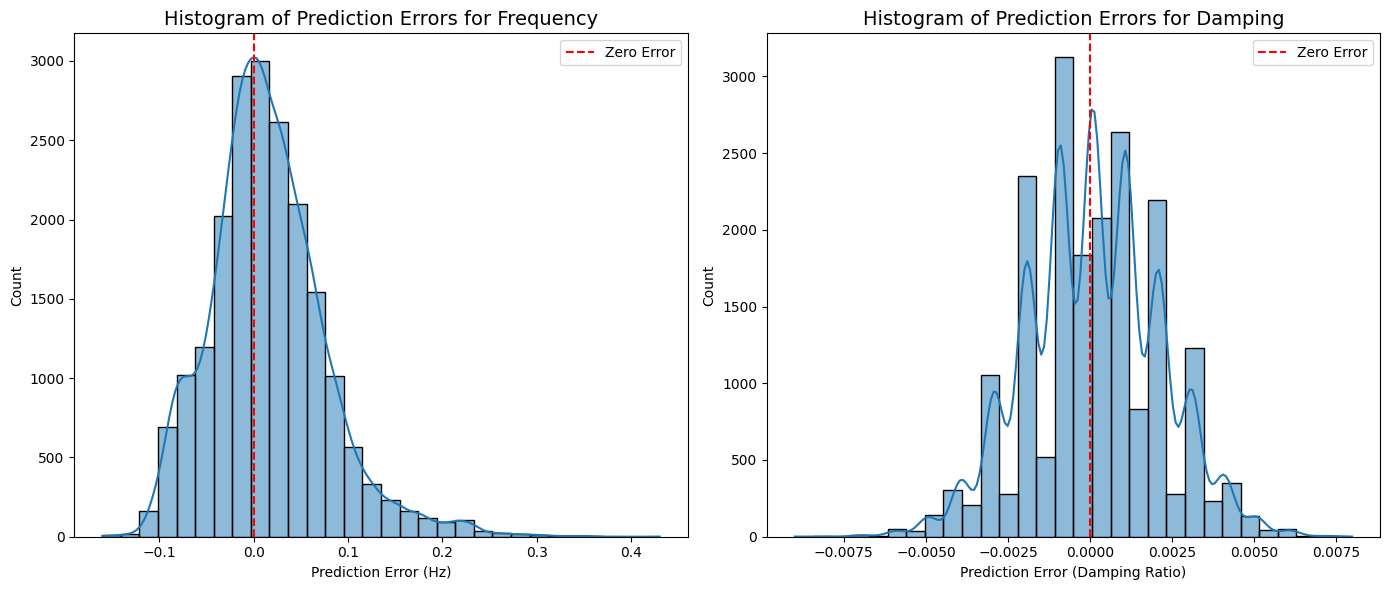

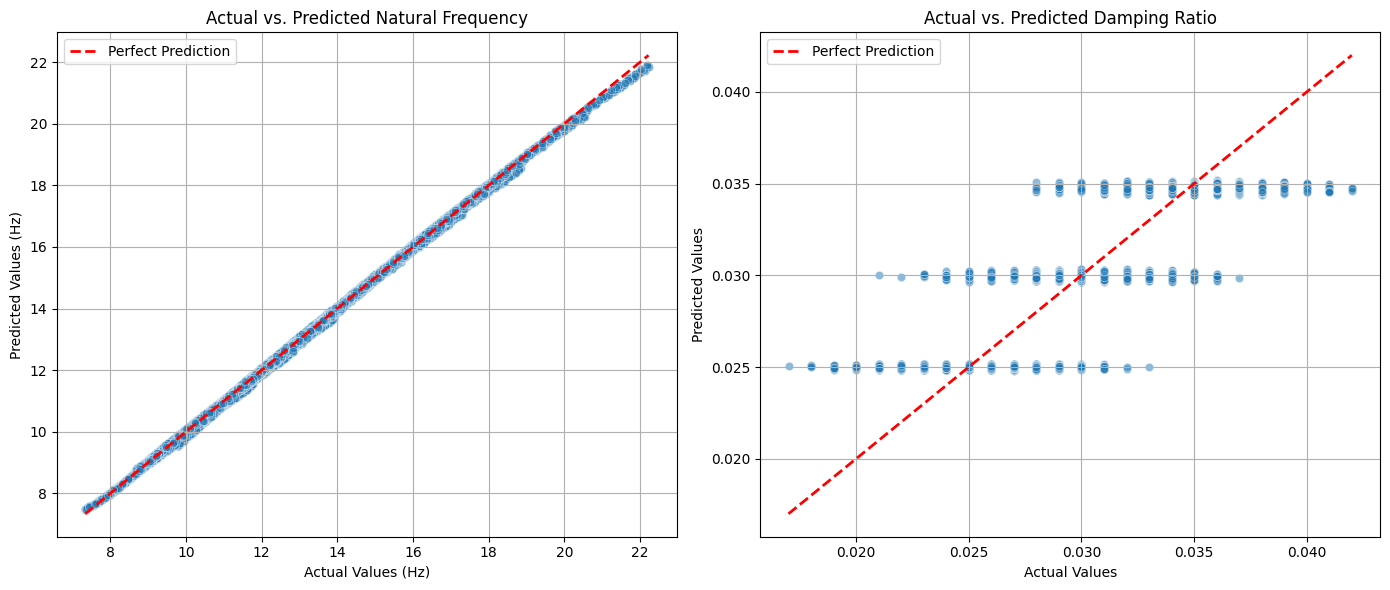

In [7]:
# --- Step 7: Evaluate Performance and Add Histogram Plot ---

# Predict and inverse transform
y_pred_scaled = model.predict(X_test_stacked)
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# --- R-squared (Performance Score) ---
print("\n--- R-squared (Performance Score) ---")
r2_freq = r2_score(y_test['Natural_Freq_Hz'], y_pred[:, 0])
r2_damp = r2_score(y_test['Damping_Ratio'], y_pred[:, 1])
print(f"Natural_Freq_Hz R-squared: {r2_freq:.4f} (Explains {r2_freq*100:.2f}% of the variance)")
print(f"Damping Ratio R-squared: {r2_damp:.4f} (Explains {r2_damp*100:.2f}% of the variance)")

# --- Sample of Actual vs. Predicted Values ---
print("\n--- Sample of Actual vs. Predicted Values ---")
results_df = pd.DataFrame({
    'Actual Natural_Freq_Hz': y_test['Natural_Freq_Hz'].values,
    'Predicted Natural_Freq_Hz': y_pred[:, 0],
    'Actual Damping_Ratio': y_test['Damping_Ratio'].values,
    'Predicted Damping_Ratio': y_pred[:, 1]
})
print(results_df.head(10).to_string())

# Calculate prediction errors (residuals)
results_df['Freq_Error'] = results_df['Actual Natural_Freq_Hz'] - results_df['Predicted Natural_Freq_Hz']
results_df['Damping_Error'] = results_df['Actual Damping_Ratio'] - results_df['Predicted Damping_Ratio']

# --- NEW: Histogram of Prediction Errors ---
plt.figure(figsize=(14, 6))

# Histogram for Natural Frequency Error
plt.subplot(1, 2, 1)
sns.histplot(results_df['Freq_Error'], kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.title('Histogram of Prediction Errors for Frequency', fontsize=14)
plt.xlabel('Prediction Error (Hz)')
plt.ylabel('Count')
plt.legend()

# Histogram for Damping Ratio Error
plt.subplot(1, 2, 2)
sns.histplot(results_df['Damping_Error'], kde=True, bins=30)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
plt.title('Histogram of Prediction Errors for Damping', fontsize=14)
plt.xlabel('Prediction Error (Damping Ratio)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()


# --- True vs. Predicted Scatter Plots ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=results_df, x='Actual Natural_Freq_Hz', y='Predicted Natural_Freq_Hz', alpha=0.5)
plt.plot([results_df['Actual Natural_Freq_Hz'].min(), results_df['Actual Natural_Freq_Hz'].max()],
         [results_df['Actual Natural_Freq_Hz'].min(), results_df['Actual Natural_Freq_Hz'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted Natural Frequency')
plt.xlabel('Actual Values (Hz)')
plt.ylabel('Predicted Values (Hz)')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
sns.scatterplot(data=results_df, x='Actual Damping_Ratio', y='Predicted Damping_Ratio', alpha=0.5)
plt.plot([results_df['Actual Damping_Ratio'].min(), results_df['Actual Damping_Ratio'].max()],
         [results_df['Actual Damping_Ratio'].min(), results_df['Actual Damping_Ratio'].max()],
         'r--', lw=2, label='Perfect Prediction')
plt.title('Actual vs. Predicted Damping Ratio')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()